# **Clasificación de textos usando LSTM y CNN**

## 1. Consigna

Las redes neuronales vienen demostrando enlos últimos años un gran desempeño a la hora de desarrollar tareas de clasificación en general, y de clasificación de textos y análisis de sentimientos en particular. Dentro de las múltiples arquitecturas posibles, destacan las familias de redes recurrentes (particularmente las Long-Short Term Memory) y las redes convolucionales. Vamos a proceder a aplicar modelos basados en estas arquitecturas para predecir la clasificación dentro de nuestro conjunto de datos.

Para la vectorización de las palabras entrenaremos al principio de los modelos un embedding neuronal de la librería torch, con la cual también generaremos los modelos de redes para entrenar.

## 2. Inicialización del entorno

In [1]:
#Librerías 
import warnings
warnings.filterwarnings("ignore")

import os
import numpy as np
import pandas as pd
from ast import literal_eval
import re
import itertools

# Para gráficos
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from yellowbrick.text import FreqDistVisualizer

# Para dividir el dataset en train  y test
from sklearn.model_selection import train_test_split
from sklearn import model_selection

# Para tratamiento de texto
from sklearn.feature_extraction.text import CountVectorizer

# Para el cálculo de tf y tf–idf 
from sklearn.feature_extraction.text import TfidfTransformer

# Algoritmo del Árbol de Decisión
from sklearn.tree import (DecisionTreeClassifier, plot_tree)

# Para utilizar Naive-Bayes para la clasificación
from sklearn.naive_bayes import MultinomialNB

# Para utilizar el algoritmo del gradiente descendiente
#from sklearn.linear_model import SGDClassifier

# Para calcular métricas
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, classification_report, plot_roc_curve, confusion_matrix) 

# Para vectorizar los tokens
from sklearn.feature_extraction.text import CountVectorizer

# Utiles
from utiles import basic_metrics
from utiles import plot_cm
from utiles import plot_roc_pr

# Colores
BLUE   = '#5DADE2'
RED    = '#ff7043'
ORANGE = '#F5B041'
GREEN  = '#58D68D'
YELLOW = '#F4D03F'

# Plot axes y legends parambs
plt.rcParams["axes.labelweight"]   = "bold"
plt.rcParams["axes.titleweight"]   = "bold"
plt.rcParams["legend.shadow"]      = True
plt.rcParams["figure.titleweight"] = "bold"

# Classes
classes = ['0 - Negativa', '1 - Positiva']

#### **Funciones**

In [2]:
# Informa los reultados obtenidos mediante la matriz de confusión (heatmap) y classification_report
def informar_resultados(y_test, pred_y, y_test_pred_prob, Title=''):
    print (classification_report(y_test, pred_y), '\n\n')
    conf_matrix = confusion_matrix(y_test, pred_y)
    plt.figure(figsize=(6, 6))
    sns.heatmap(conf_matrix, xticklabels=classes, yticklabels=classes, annot=True, fmt="d", cmap='Greens', linecolor='black', linewidths=1, square=True, cbar=False);
    plt.title(Title + " - Matriz de Confusión")
    plt.ylabel('Real')
    plt.xlabel('Predicción')
    plt.show()
    plot_roc_pr(y_test,  pred_y, y_test_pred_prob, Title= Title + ' - ROC PR',  x_text=0.4, y_text=0.2, size_text=12, size=(12,5), ms=15, colorR=ORANGE, colorP=GREEN, label=None);

## 3. Carga de datos 

El archivo **yup_curated_data.csv** se genera a partir del archivo yup_messages_preprocessed.csv y datadump-20150801-20171219.csv y se cura para aplicar sobre el mismo técnicas de procesamiento del lenguaje natural. La curación de dicho archivo fue realizada en la notebook [Practico_3y4_part_2y3_preparacion](https://github.com/giannipablo/MentoriaDiploDatos2020/blob/master/Practico_3y4_part_2y3_preparacion.ipynb)

In [3]:
# Desde Colab
#from google.colab import files   
#uploaded = files.upload()

In [4]:
# Desde el entorno local
filename = 'yup_curated_data.csv'
datos_curados = pd.read_csv(os.path.join('..', 'dataset', filename))

#### Dimensiones del dataset *datos curados*.

In [5]:
print ('\nDimensiones del dataset\n')
print ('Filas: {}'.format(datos_curados.shape[0]))
print ('Columnas: {}'.format(datos_curados.shape[1]))


Dimensiones del dataset

Filas: 17429
Columnas: 22


## 4. Limpieza de datos

#### **Remoción de las sesiones con pocos turnos del estudiante o del tutor**

Cuando las sesiones cuenten con menos de 3 turnos del estudiante o del tutor se considera que el intercambio no es significativo por lo que se remueven dichas sesiones. 

In [6]:
n_short_sessions = len(datos_curados[(datos_curados.n_msg_tutor < 3) | (datos_curados.n_msg_student < 3)])
datos_curados = datos_curados.drop(datos_curados[(datos_curados.n_msg_tutor < 3) | (datos_curados.n_msg_student < 3)].index)

print('\nDel dataset datos curados se remueven en total {} sesiones con menos de 3 turnos del estudiante o del tutor\n'.format(n_short_sessions))


Del dataset datos curados se remueven en total 1124 sesiones con menos de 3 turnos del estudiante o del tutor



#### **Remoción de las sesiones con la columna de tokens del estudiante o del tutor nula**

Se remueven aquellos diálogos sin información en las columnas de tokens del tutor o del estudiante.

In [7]:
n_null_token_tutor = datos_curados['tokens_tutor'].isnull().sum()
n_null_token_student = datos_curados['tokens_student'].isnull().sum()
datos_curados = datos_curados.dropna(subset=['tokens_tutor','tokens_student'])
print('\nSe remueven {} sesiones sin tokens del tutor'.format(n_null_token_tutor))
print('\nSe remueven {} sesiones sin tokens del estudiante'.format(n_null_token_student))


print ('\nDimensiones del dataset\n')
print ('Filas: {}'.format(datos_curados.shape[0]))
print ('Columnas: {}'.format(datos_curados.shape[1]))


Se remueven 0 sesiones sin tokens del tutor

Se remueven 0 sesiones sin tokens del estudiante

Dimensiones del dataset

Filas: 16305
Columnas: 22


#### **Unificación de las expresiones algebraicas bajo el tag math**

Debido a que los sesiones corresponden a diálogos que contienen consultas sobre química, física o matemática, los mismos pueden contener fórmulas matemáticas. Por lo tanto, se decide unificar los unigramas que contienen al menos un dígito y al menos un operador algebraico bajo el tag **math** usando una expresión regular.

In [8]:
datos_curados['tokens_tutor'] = datos_curados.tokens_tutor.apply(lambda x: literal_eval(x))
datos_curados['tokens_student'] = datos_curados.tokens_student.apply(lambda x: literal_eval(x))

# Utilizamos expresiones regulares para unificar los unigramas bajo el tag <math>

r = re.compile('((?=.*[0-9])(?=.*[%\/\(\)\^\\\+\-\*\=]))^.*')
datos_curados['tokens_tutor'] = datos_curados.tokens_tutor.apply(lambda x: ['<math>' if r.match(w) else w for w in x])
datos_curados['tokens_student'] = datos_curados.tokens_student.apply(lambda x: ['<math>' if r.match(w) else w for w in x])

datos_curados['tokens_tutor'] = datos_curados.tokens_tutor.apply(lambda x: str(x)[1:-1])
datos_curados['tokens_student'] = datos_curados.tokens_student.apply(lambda x: str(x)[1:-1])

### stopwords

procederemos a la eliminación de stopwords, es decir, palabras muy frecuentes y muy poco informativas que sirven para enriquecimiento del lenguaje pero que no aportan significado. Además, removeremos aquellos signos de puntuación, ya que si bien pueden aportar cierta información, en general pueden introducir ruido no deseado a los modelos.

In [9]:
datos_curados_nonstop = datos_curados.copy()

In [10]:
from nltk.corpus import stopwords
from string import punctuation

In [11]:
english_stopwords = stopwords.words('english')
non_words = list(punctuation)
non_words.append('')
def remove_stopwords(text):  
    # remove punctuation
    out = []
    text = text.replace("\'","").lower()#.replace("'\'","").replace("\'","")
    text = text.split(", ")
    text = [c for c in text if c not in non_words]
    for t in text:
        if t not in english_stopwords:
            out.append(t)
    return out


In [12]:
non_words

['!',
 '"',
 '#',
 '$',
 '%',
 '&',
 "'",
 '(',
 ')',
 '*',
 '+',
 ',',
 '-',
 '.',
 '/',
 ':',
 ';',
 '<',
 '=',
 '>',
 '?',
 '@',
 '[',
 '\\',
 ']',
 '^',
 '_',
 '`',
 '{',
 '|',
 '}',
 '~',
 '']

In [13]:
datos_curados_nonstop['tokens_tutor'] = datos_curados_nonstop.tokens_tutor.apply(lambda x: remove_stopwords(x))
datos_curados_nonstop['tokens_student'] = datos_curados_nonstop.tokens_student.apply(lambda x: remove_stopwords(x))

#### **Primeras filas de la columna 'tokens_tutor', la cual contiene texto de interés para el análisis.**

In [14]:
datos_curados_nonstop['tokens_tutor'].head()[0]

['hey',
 'robert',
 'welcome',
 'yup',
 'looking',
 'problem',
 '"ve"',
 'reviewed',
 'problem',
 'finding',
 'domain',
 'square',
 'root',
 'function',
 'let',
 '"s"',
 'work',
 'together',
 'find',
 'exactly',
 '"re"',
 'stuck',
 'tried',
 'work',
 'okay',
 'actually',
 'need',
 'find',
 'domain',
 'square',
 'root',
 'function',
 'need',
 'simplify',
 'however',
 'simplify',
 'would',
 '"nt"',
 'wrong',
 'please',
 'show',
 'check',
 'okay',
 'appreciate',
 'work',
 '"nt"',
 'seem',
 'relevant',
 'work',
 'let',
 '"s"',
 'discuss',
 'problem',
 'together',
 'move',
 'tell',
 'mean',
 'word',
 'domain',
 'meant',
 'learned',
 'domain',
 'far',
 '"s"',
 'good',
 'x',
 'values',
 'defined',
 'said',
 'domain',
 'function',
 'let',
 'explain',
 'main',
 'concept',
 'use',
 'find',
 'domain',
 'square',
 'root',
 'function',
 'since',
 'expression',
 'written',
 'inside',
 'square',
 'root',
 'never',
 'lesser',
 'zero',
 'set',
 'expression',
 'equal',
 'greater',
 'zero',
 'solve',
 'x

In [15]:
datos_curados_nonstop['student_rating_cat'].head()

0    1
1    0
2    1
3    1
4    1
Name: student_rating_cat, dtype: int64

In [16]:
datos_finales = datos_curados_nonstop[['tokens_tutor','student_rating_cat']]

Removemos aquellos diálogos con una palabra o menos, ya que es muy dificil que los mismos aporten información suficiente para su clasificación, o para la elaboración de una etiqueta confiable.

In [17]:
from collections import Counter
counts = Counter()
for index, row in datos_finales.iterrows():
    counts.update(row['tokens_tutor'])

In [18]:
print("num_words before:",len(counts.keys()))
for word in list(counts):
    if counts[word] < 2:
        del counts[word]
print("num_words after:",len(counts.keys()))

num_words before: 33107
num_words after: 17954


In [19]:
datos_finales

,tokens_tutor,student_rating_cat
0,"[hey, robert, welcome, yup, looking, problem, ...",1
1,"[hello, sophie, welcome, yup, please, give, mi...",0
2,"[hello, illuminati, :), welcome, yup, personal...",1
3,"[hi, domingo, welcome, yup, may, help, today, ...",1
4,"[hello, jasmyn, :), welcome, yup, thank, shari...",1
...,...,...
17423,"[hi, lena, welcome, yup, start, please, let, k...",1
17424,"[hello, steven, :), welcome, yup, problem, cou...",0
17425,"[hey, natalia, welcome, yup, much, progress, m...",1
17426,"[hi, name, m., jesus, tutor, session, fine, pr...",1


Vamos a truncar el número de palabras máximo de un diálogo en 250, redondeando en un valor cercano al tercer cuartil (75%) de las longitudes de los diálogos. Realizamos esto para normalizar las dimensiones de los diálogos, ya que existen unos pocos que tienen miles de palabras, y que podemos conisderar como outliers. Además, con propósito de generar una representación numérica de las palabras para alimentar el embedding, definimos una biyección entre las palabras únicas del dataset y un número entero identificatorio.

In [20]:
datos_finales['tokens_tutor'].apply(len).quantile(q=.75)

244.0

In [21]:
vocab2index = {"":0, "UNK":1}
words = ["", "UNK"]
for word in counts:
    vocab2index[word] = len(words)
    words.append(word)

In [22]:
def encode_sentence(text, vocab2index, N=250):
    encoded = np.zeros(N, dtype=int)
    enc1 = np.array([vocab2index.get(word, vocab2index["UNK"]) for word in text])
    length = min(N, len(enc1))
    encoded[:length] = enc1[:length]
    return encoded, length

In [23]:
datos_finales['encoded'] = datos_finales['tokens_tutor'].apply(lambda x: np.array(encode_sentence(x,vocab2index )))
datos_finales.head()

,tokens_tutor,student_rating_cat,encoded
0,"[hey, robert, welcome, yup, looking, problem, ...",1,"[[2, 3, 4, 5, 6, 7, 8, 9, 7, 10, 11, 12, 13, 1..."
1,"[hello, sophie, welcome, yup, please, give, mi...",0,"[[68, 69, 4, 5, 32, 70, 71, 72, 7, 73, 74, 75,..."
2,"[hello, illuminati, :), welcome, yup, personal...",1,"[[68, 1, 77, 4, 5, 78, 79, 80, 81, 82, 83, 84,..."
3,"[hi, domingo, welcome, yup, may, help, today, ...",1,"[[139, 140, 4, 5, 141, 80, 142, 143, 144, 85, ..."
4,"[hello, jasmyn, :), welcome, yup, thank, shari...",1,"[[68, 314, 77, 4, 5, 304, 315, 87, 32, 70, 145..."


In [24]:
datos_finales['weight'] = datos_finales.student_rating_cat.apply(lambda x: 0.18 if x == 1 else 0.82)

Generamos los conjuntos de datos de entrenamiento y validación, con una proporción 80/20.

In [25]:
X = datos_finales[['encoded','weight']]
y = list(datos_finales['student_rating_cat'])
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2)

In [26]:
X_train

,encoded,weight
13826,"[[139, 4452, 4, 5, 77, 7, 77, 32, 70, 71, 181,...",0.18
7997,"[[139, 11764, 1401, 5096, 5323, 883, 79, 151, ...",0.82
13344,"[[68, 6253, 4, 5, 77, 877, 7, 469, 137, 116, 6...",0.18
8664,"[[68, 4872, 4, 5, 77, 8, 9, 7, 40, 8, 23, 75, ...",0.18
4277,"[[68, 9072, 77, 4, 5, 8, 1391, 7, 15, 16, 17, ...",0.82
...,...,...
12409,"[[139, 7232, 4, 5, 1401, 5096, 5142, 883, 79, ...",0.82
449,"[[68, 3468, 77, 4, 5, 32, 70, 145, 181, 7, 181...",0.18
9420,"[[68, 4488, 4, 5, 77, 1401, 4880, 11381, 83, 7...",0.18
6484,"[[68, 1268, 77, 4, 5, 8, 9, 7, 77, 524, 19, 33...",0.18


Importamos las librerías necesarias para el entrenamiento de las redes.

In [27]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from sklearn.metrics import mean_squared_error, f1_score

Definimos la forma final del dataset.

In [28]:
class ScoringDataset(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.y = Y
        
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        return torch.from_numpy(list(self.X['encoded'])[idx][0].astype(np.int32)), self.y[idx], list(self.X['encoded'])[idx][1]

In [29]:
train_ds = ScoringDataset(X_train, y_train)
valid_ds = ScoringDataset(X_valid, y_valid)

Definimos las funciones de entrenamiento y métricas de validación de las redes, utilizando una función de costo de entropía cruzada binaria (la función de costo mas común a la hora de clasificación binaria). La versión particular que utilizamos de esta función de costo, tiene incluida la normalización de la salida del modelo, por lo cual no hay que agregar una función de decisión a la salida de los mismos. Además, utilizamos un argumento en la función de costo que nos permite agregar un peso a cada clase, con lo cual podemos abordar el desbalance de clases que presenta nuestro dataset en particular.

In [33]:
losss = nn.BCEWithLogitsLoss().cuda()
sampler = torch.utils.data.sampler.WeightedRandomSampler(list(X_train['weight']),len(list(X_train['weight'])))
def train_model(model, epochs=10, lr=0.001):
    parameters = filter(lambda p: p.requires_grad, model.parameters())
    optimizer = torch.optim.Adam(parameters, lr=lr, weight_decay=1e-5)
    for i in range(epochs):
        model.train().cuda()
        sum_loss = 0.0
        total = 0
        for x, y, l in train_dl:
            x = x.cuda().long()
            y = F.one_hot(y.cuda(),2)
            y_pred = model(x, l)
            y = y.type_as(y_pred)
            optimizer.zero_grad()
            loss = losss(y_pred, y)
            loss.backward()
            optimizer.step()
            sum_loss += loss.item()*y.shape[0]
            total += y.shape[0]
        val_loss, val_acc, val_rmse, ff1, ff1macro, ff1weight = validation_metrics(model, val_dl)
        
        print("train loss %.3f, val loss %.3f, val accuracy %.3f, val rmse %.3f, val f1 %.3f, val f1macro %.3f, val f1weight %.3f" % (sum_loss/total, val_loss, val_acc, val_rmse, ff1,ff1macro, ff1weight))

def validation_metrics (model, valid_dl):
    model.eval().cpu()
    correct = 0
    total = 0
    sum_loss = 0.0
    sum_rmse = 0.0
    sum_f1 = 0.0
    predy=[]
    truey=[]
    for x, y, l in valid_dl:
        x = x.long()
        y = y.long()
        y_hat = model(x, l)
        loss = F.cross_entropy(y_hat, y)
        pred = torch.max(y_hat, 1)[1]
        correct += (pred == y).float().sum()
        total += y.shape[0]
        sum_loss += loss.item()*y.shape[0]
        sum_rmse += np.sqrt(mean_squared_error(pred, y.unsqueeze(-1)))*y.shape[0]

    for i in range(len(valid_ds)):
        a,b,c = valid_ds[i]
        predy.append(model_fixed(a.long().unsqueeze(0),c).detach().numpy().argmax())
        truey.append(b)
    ff1 = f1_score(truey,predy)
    ff1macro = f1_score(truey,predy, average='macro')
    ff1weight = f1_score(truey,predy, average='weighted')
    return sum_loss/total, correct/total, sum_rmse/total, ff1, ff1macro, ff1weight

Definimos los dataloaders, que son herramientas de torch que nos permiten crear un generador a partir del dataset, el cual agrupa datos en función del tamaño de batch, y nos permite randomizar la entrada.

In [34]:
batch_size = 2500
vocab_size = len(words)
train_dl = DataLoader(train_ds, batch_size=batch_size, sampler=sampler)
val_dl = DataLoader(valid_ds, batch_size=batch_size)

Definimos la arquitectura del modelo LSTM. El mismo consta, además del embedding inicial, de una capa LSTM, y una capa lineal. Utilizamos además dropout como método de regularización, el cual consiste en apagar ciertas neuronas aleatorias durante el entrenamiento, lo cual permite al modelo generalizar mejor y evitar el sobreajuste.

In [49]:
class LSTM_fixed_len(torch.nn.Module) :
    def __init__(self, vocab_size, embedding_dim, hidden_dim) :
        super().__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.linear = nn.Linear(hidden_dim, 2)
        self.dropout = nn.Dropout(0.2)
        
    def forward(self, x, l):
        x = self.embeddings(x)
        x = self.dropout(x)
        lstm_out, (ht, ct) = self.lstm(x)
        return self.linear(ht[-1])

Instanciamos el modelo, con el tamaño de nuestro vocabulario para entrenar el embedding, y con dimensión del embedding igual a 50. Además, definimos la dimensión de neuronas ocultas en la capa LSTM como 50.

In [50]:
model_fixed =  LSTM_fixed_len(vocab_size, 50, 50)

Entrenamos el modelo, con learning rate de 0.01 y 60 épocas.

In [54]:
train_model(model_fixed, epochs=20, lr=0.01)

train loss 0.686, val loss 0.784, val accuracy 0.379, val rmse 0.788, val f1 0.412, val f1macro 0.377, val f1weight 0.400
train loss 0.735, val loss 0.727, val accuracy 0.394, val rmse 0.778, val f1 0.436, val f1macro 0.391, val f1weight 0.420
train loss 0.665, val loss 0.792, val accuracy 0.378, val rmse 0.788, val f1 0.411, val f1macro 0.376, val f1weight 0.399
train loss 0.668, val loss 0.748, val accuracy 0.380, val rmse 0.787, val f1 0.414, val f1macro 0.378, val f1weight 0.401
train loss 0.664, val loss 0.901, val accuracy 0.383, val rmse 0.785, val f1 0.419, val f1macro 0.381, val f1weight 0.405
train loss 0.660, val loss 0.718, val accuracy 0.396, val rmse 0.777, val f1 0.438, val f1macro 0.392, val f1weight 0.421
train loss 0.660, val loss 0.734, val accuracy 0.456, val rmse 0.738, val f1 0.529, val f1macro 0.442, val f1weight 0.498
train loss 0.675, val loss 0.518, val accuracy 0.810, val rmse 0.436, val f1 0.894, val f1macro 0.505, val f1weight 0.754
train loss 0.658, val lo

In [55]:
train_model(model_fixed, epochs=20, lr=0.01)

train loss 0.601, val loss 0.616, val accuracy 0.727, val rmse 0.523, val f1 0.824, val f1macro 0.606, val f1weight 0.745
train loss 0.600, val loss 1.041, val accuracy 0.365, val rmse 0.797, val f1 0.388, val f1macro 0.364, val f1weight 0.379
train loss 0.578, val loss 0.832, val accuracy 0.736, val rmse 0.514, val f1 0.832, val f1macro 0.608, val f1weight 0.751
train loss 0.559, val loss 0.743, val accuracy 0.744, val rmse 0.506, val f1 0.839, val f1macro 0.608, val f1weight 0.756
train loss 0.578, val loss 0.820, val accuracy 0.390, val rmse 0.781, val f1 0.429, val f1macro 0.388, val f1weight 0.414
train loss 0.561, val loss 1.019, val accuracy 0.396, val rmse 0.777, val f1 0.436, val f1macro 0.393, val f1weight 0.420
train loss 0.561, val loss 0.892, val accuracy 0.381, val rmse 0.787, val f1 0.414, val f1macro 0.379, val f1weight 0.401
train loss 0.556, val loss 0.769, val accuracy 0.767, val rmse 0.483, val f1 0.860, val f1macro 0.584, val f1weight 0.761
train loss 0.553, val lo

In [56]:
train_model(model_fixed, epochs=20, lr=0.01)

train loss 0.461, val loss 0.979, val accuracy 0.622, val rmse 0.615, val f1 0.712, val f1macro 0.580, val f1weight 0.665
train loss 0.425, val loss 0.746, val accuracy 0.722, val rmse 0.528, val f1 0.809, val f1macro 0.646, val f1weight 0.751
train loss 0.404, val loss 0.986, val accuracy 0.691, val rmse 0.556, val f1 0.781, val f1macro 0.628, val f1weight 0.726
train loss 0.381, val loss 1.010, val accuracy 0.701, val rmse 0.547, val f1 0.791, val f1macro 0.634, val f1weight 0.734
train loss 0.365, val loss 0.978, val accuracy 0.711, val rmse 0.538, val f1 0.800, val f1macro 0.638, val f1weight 0.742
train loss 0.351, val loss 1.007, val accuracy 0.705, val rmse 0.543, val f1 0.795, val f1macro 0.634, val f1weight 0.737
train loss 0.341, val loss 1.026, val accuracy 0.718, val rmse 0.531, val f1 0.807, val f1macro 0.643, val f1weight 0.748
train loss 0.339, val loss 0.973, val accuracy 0.722, val rmse 0.527, val f1 0.810, val f1macro 0.645, val f1weight 0.751
train loss 0.320, val lo

Definimos la arquitectura del modelo CNN. El mismo consta, además del embedding inicial, de cuatro capas convolucionales paralelas, con distinto tamaño de kernel (lo cual se puede comparar con distintas longitudes de n-gramas), cuyo resultado luego pasa por un max pooling, y luego se concatenan los resultados aplanados en un vector unidimensional, y este se utiliza como entrada en una capa lineal. Utilizamos además dropout como método de regularización, el cual consiste en apagar ciertas neuronas aleatorias durante el entrenamiento, lo cual permite al modelo generalizar mejor y evitar el sobreajuste.

In [30]:
import math

In [41]:
import torch.nn.functional as F

class TextClassifier(nn.ModuleList):

    def __init__(self):
        super(TextClassifier, self).__init__()
        # Parameters regarding text preprocessing
        self.seq_len = 250
        self.num_words = vocab_size
        self.embedding_size = 50
        
        # Dropout definition
        self.dropout = nn.Dropout(0.25)
        
        # CNN parameters definition
        # Kernel sizes
        self.kernel_1 = 2
        self.kernel_2 = 3
        self.kernel_3 = 4
        self.kernel_4 = 5
        
        # Output size for each convolution
        self.out_size = 8
        # Number of strides for each convolution
        self.stride = 1
        
        # Embedding layer definition
        self.embedding = nn.Embedding(self.num_words, self.embedding_size, padding_idx=0)
        
        # Convolution layers definition
        self.conv_1 = nn.Conv1d(self.embedding_size, self.out_size, self.kernel_1, self.stride)
        self.conv_2 = nn.Conv1d(self.embedding_size, self.out_size, self.kernel_2, self.stride)
        self.conv_3 = nn.Conv1d(self.embedding_size, self.out_size, self.kernel_3, self.stride)
        self.conv_4 = nn.Conv1d(self.embedding_size, self.out_size, self.kernel_4, self.stride)
        
        # Max pooling layers definition
        self.pool_1 = nn.MaxPool1d(self.kernel_1, self.stride)
        self.pool_2 = nn.MaxPool1d(self.kernel_2, self.stride)
        self.pool_3 = nn.MaxPool1d(self.kernel_3, self.stride)
        self.pool_4 = nn.MaxPool1d(self.kernel_4, self.stride)
        
        # Fully connected layer definition
        self.fc = nn.Linear(980*self.out_size, 2)

        
        
    def forward(self, x, l):

        # Sequence of tokes is filterd through an embedding layer
        x = self.embedding(x)
        x = x.permute(0,2,1)
        # Convolution layer 1 is applied
        x1 = self.conv_1(x)
        x1 = torch.relu(x1)
        x1 = self.pool_1(x1)
        # Convolution layer 2 is applied
        x2 = self.conv_2(x)
        x2 = torch.relu((x2))
        x2 = self.pool_2(x2)
    
        # Convolution layer 3 is applied
        x3 = self.conv_3(x)
        x3 = torch.relu(x3)
        x3 = self.pool_3(x3)
        
        # Convolution layer 4 is applied
        x4 = self.conv_4(x)
        x4 = torch.relu(x4)
        x4 = self.pool_4(x4)
        
        # The output of each convolutional layer is concatenated into a unique vector
        union = torch.cat((x1, x2, x3, x4), 2)
        union = union.reshape(union.size(0), -1)

        # The "flattened" vector is passed through a fully connected layer
        out = self.fc(union)
        # Dropout is applied        
        out = self.dropout(out)
        # Activation function is applied
        
        return out.squeeze()

In [42]:
losss = nn.BCEWithLogitsLoss().cuda()
sampler = torch.utils.data.sampler.WeightedRandomSampler(list(X_train['weight']),len(list(X_train['weight'])))
model = TextClassifier()
def train_model(model, epochs=10, lr=0.001):
    parameters = filter(lambda p: p.requires_grad, model.parameters())
    optimizer = torch.optim.Adam(parameters, lr=lr, weight_decay=1e-5)
    for i in range(epochs):
        model.train().cuda()
        sum_loss = 0.0
        total = 0
        for x, y, l in train_dl:
            x = x.cuda().long()
            y = F.one_hot(y.cuda(),2)
            y_pred = model(x, l)
            y = y.type_as(y_pred)
            optimizer.zero_grad()
            loss = losss(y_pred, y)
            loss.backward()
            optimizer.step()
            sum_loss += loss.item()*y.shape[0]
            total += y.shape[0]
        val_loss, val_acc, val_rmse, ff1, ff1macro, ff1weight = validation_metrics(model, val_dl)
        
        print("train loss %.3f, val loss %.3f, val accuracy %.3f, val rmse %.3f, val f1 %.3f, val f1macro %.3f, val f1weight %.3f" % (sum_loss/total, val_loss, val_acc, val_rmse, ff1,ff1macro, ff1weight))
def validation_metrics (model, valid_dl):
    model.eval().cpu()
    correct = 0
    total = 0
    sum_loss = 0.0
    sum_rmse = 0.0
    sum_f1 = 0.0
    predy=[]
    truey=[]
    for x, y, l in valid_dl:
        x = x.long()
        y = y.long()
        y_hat = model(x, l)
        loss = F.cross_entropy(y_hat, y)
        pred = torch.max(y_hat, 1)[1]
        correct += (pred == y).float().sum()
        total += y.shape[0]
        sum_loss += loss.item()*y.shape[0]
        sum_rmse += np.sqrt(mean_squared_error(pred, y.unsqueeze(-1)))*y.shape[0]

    for i in range(len(valid_ds)):
        a,b,c = valid_ds[i]
        predy.append(model(a.long().unsqueeze(0),c).detach().numpy().argmax())
        truey.append(b)
    ff1 = f1_score(truey,predy)
    ff1macro = f1_score(truey,predy, average='macro')
    ff1weight = f1_score(truey,predy, average='weighted')
    return sum_loss/total, correct/total, sum_rmse/total, ff1, ff1macro, ff1weight

In [43]:
train_model(model, epochs=20, lr=0.01)

train loss 2.427, val loss 1.230, val accuracy 0.197, val rmse 0.896, val f1 0.048, val f1macro 0.177, val f1weight 0.094
train loss 0.951, val loss 0.659, val accuracy 0.556, val rmse 0.667, val f1 0.662, val f1macro 0.507, val f1weight 0.606
train loss 0.748, val loss 0.630, val accuracy 0.590, val rmse 0.641, val f1 0.697, val f1macro 0.531, val f1weight 0.637
train loss 0.688, val loss 0.681, val accuracy 0.541, val rmse 0.677, val f1 0.642, val f1macro 0.502, val f1weight 0.591
train loss 0.654, val loss 0.730, val accuracy 0.530, val rmse 0.686, val f1 0.626, val f1macro 0.496, val f1weight 0.579
train loss 0.626, val loss 0.663, val accuracy 0.641, val rmse 0.599, val f1 0.742, val f1macro 0.576, val f1weight 0.682
train loss 0.611, val loss 0.710, val accuracy 0.601, val rmse 0.632, val f1 0.699, val f1macro 0.554, val f1weight 0.647
train loss 0.583, val loss 0.616, val accuracy 0.672, val rmse 0.572, val f1 0.770, val f1macro 0.602, val f1weight 0.709
train loss 0.563, val lo

In [44]:
train_model(model, epochs=20, lr=0.01)

train loss 0.370, val loss 1.067, val accuracy 0.749, val rmse 0.501, val f1 0.835, val f1macro 0.656, val f1weight 0.771
train loss 0.307, val loss 0.886, val accuracy 0.796, val rmse 0.451, val f1 0.874, val f1macro 0.674, val f1weight 0.802
train loss 0.292, val loss 1.144, val accuracy 0.775, val rmse 0.474, val f1 0.857, val f1macro 0.668, val f1weight 0.789
train loss 0.271, val loss 1.095, val accuracy 0.766, val rmse 0.483, val f1 0.851, val f1macro 0.652, val f1weight 0.780
train loss 0.258, val loss 1.273, val accuracy 0.767, val rmse 0.483, val f1 0.851, val f1macro 0.659, val f1weight 0.782
train loss 0.246, val loss 1.272, val accuracy 0.768, val rmse 0.482, val f1 0.854, val f1macro 0.647, val f1weight 0.779
train loss 0.231, val loss 1.363, val accuracy 0.787, val rmse 0.462, val f1 0.868, val f1macro 0.653, val f1weight 0.791
train loss 0.219, val loss 1.441, val accuracy 0.786, val rmse 0.462, val f1 0.868, val f1macro 0.656, val f1weight 0.792
train loss 0.218, val lo

In [45]:
train_model(model, epochs=20, lr=0.001)

train loss 0.181, val loss 2.160, val accuracy 0.786, val rmse 0.463, val f1 0.869, val f1macro 0.641, val f1weight 0.787
train loss 0.181, val loss 2.182, val accuracy 0.793, val rmse 0.455, val f1 0.874, val f1macro 0.641, val f1weight 0.790
train loss 0.181, val loss 2.194, val accuracy 0.787, val rmse 0.462, val f1 0.870, val f1macro 0.639, val f1weight 0.787
train loss 0.185, val loss 2.215, val accuracy 0.792, val rmse 0.456, val f1 0.874, val f1macro 0.639, val f1weight 0.789
train loss 0.178, val loss 2.223, val accuracy 0.791, val rmse 0.458, val f1 0.873, val f1macro 0.643, val f1weight 0.790
train loss 0.180, val loss 2.236, val accuracy 0.789, val rmse 0.459, val f1 0.872, val f1macro 0.640, val f1weight 0.788
train loss 0.181, val loss 2.249, val accuracy 0.792, val rmse 0.456, val f1 0.874, val f1macro 0.640, val f1weight 0.790
train loss 0.181, val loss 2.258, val accuracy 0.785, val rmse 0.464, val f1 0.869, val f1macro 0.638, val f1weight 0.786
train loss 0.179, val lo

Al observar la métrica de referencia sobre el conjunto de validación (f1 macro) podemos notar que ambos modelos convergen a valores similares. Podemos notar que el modelo LSTM llega a valores pico un poco menores que el modelo CNN a través de las épocas, pero también es más regular, es decir, luego de las épocas necesarias para alcanzar el valor pico, el modelo se estabiliza bastante sobre esta métrica, es decir, este modelo previene mejor el sobreajuste que el modelo CNN, que si bien alcanza un valor pico mayor, luego decrece su rendimiento. Esto puede solucionarse con una regularización más fuerte en el modelo CNN, ya sea agregando normalización en batch o aumentando el término de regularización l2 en el optimizador. Veamos que la cantidad de parámetros de los modelos es comparable.

In [47]:
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])

Número de parámetros entrenables en el modelo CNN

In [48]:
params

919114

In [51]:
model_parameters = filter(lambda p: p.requires_grad, model_fixed.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])

Número de parámetros entrenables en el modelo LSTM

In [53]:
params

918302

In [58]:
def sigmoid(x):
    return 1 / (1 + math.exp(-x))

In [67]:
predy_cnn = []
predy_cnn_prob = []
predy_lstm = []
predy_lstm_prob = []
truey = []
model_fixed.eval()
model.eval()
for i in range(len(valid_ds)):
    a,b,c = valid_ds[i]
    predy_lstm.append(model_fixed(a.long().unsqueeze(0),c).detach().numpy().argmax())
    predy_lstm_prob.append(sigmoid(model_fixed(a.long().unsqueeze(0),c).detach().numpy()[:,1]))
    predy_cnn.append(model(a.long().unsqueeze(0),c).detach().numpy().argmax())
    predy_cnn_prob.append(sigmoid(model(a.long().unsqueeze(0),c).detach().numpy()[1]))
    truey.append(b)

              precision    recall  f1-score   support

           0       0.39      0.41      0.40       587
           1       0.87      0.86      0.87      2674

    accuracy                           0.78      3261
   macro avg       0.63      0.63      0.63      3261
weighted avg       0.78      0.78      0.78      3261
 




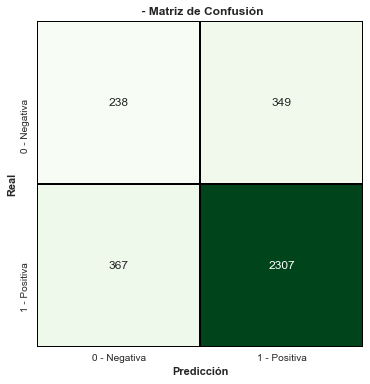

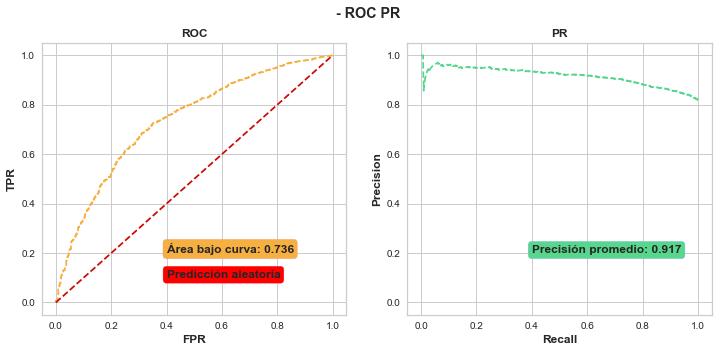

In [68]:
informar_resultados(truey, predy_cnn, predy_cnn_prob)

              precision    recall  f1-score   support

           0       0.38      0.65      0.48       587
           1       0.91      0.77      0.84      2674

    accuracy                           0.75      3261
   macro avg       0.65      0.71      0.66      3261
weighted avg       0.81      0.75      0.77      3261
 




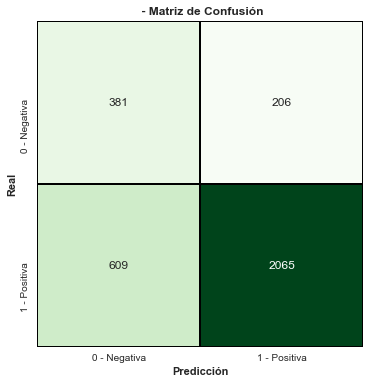

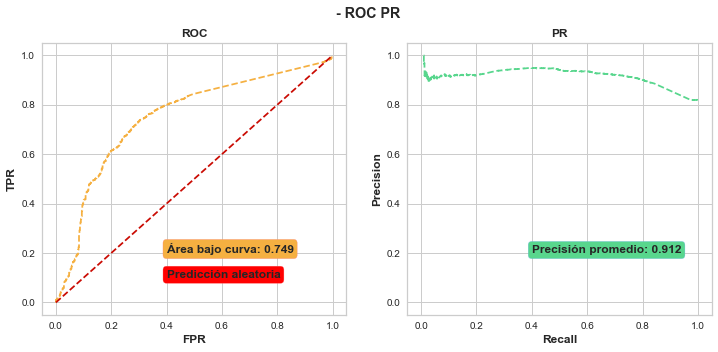

In [69]:
informar_resultados(truey, predy_lstm, predy_lstm_prob)

## **Conclusiones**
Ambos modelos presentan un desempeño muy similar, y comparable a los modelos de clasificación clásicos con el mejor tratamiento de datos posible. Esto es positivo, ya que en estos modelos no tuvimos que aplicar criterios de selección de palabras ni de texto, y de todas maneras obtuvimos resultados comparables.
Las desventajas que presentan estos modelos son principalmente la no interpretabilidad de los mismos, ya que es muy dificil conocer la relación entre las variables de entrada y la salida final, y sobre todo el tiempo y la capacidad de cómputo, ya que estos modelos fueron entrenados sobre GPU, sin lo cual se hacen muy lentos.

### **Referencias**

[Capa LSTM](https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html)

[Capa Convolucional 1d](https://pytorch.org/docs/stable/generated/torch.nn.Conv1d.html)



[Embedding de palabras en Torch](https://pytorch.org/docs/stable/generated/torch.nn.Embedding.html)




